# Computer Vision with Classical Machine Learning
## ITAI 1378 Module 03 - Hands-On Lab

### Welcome!

 We'll go step-by-step through the process of building a computer vision model using classical machine learning techniques. No prior experience in computer vision is required!

**Why Classical Machine Learning for Computer Vision?**
While deep learning is popular today, classical ML techniques are still incredibly valuable. They are:
- **Efficient**: They require less data and computational power.
- **Interpretable**: We can understand *why* the model makes its decisions.
- **A great foundation**: Understanding classical ML will make you a better deep learning practitioner.

### 🎯 Learning Objectives
By the end of this lab, you will:
1. **Understand the complete classical ML pipeline** for computer vision.
2. **Extract and compare different feature types** (HOG, SIFT, LBP, etc.).
3. **Implement multiple ML algorithms** and understand their strengths.
4. **🚨 CRITICALLY IMPORTANT**: Understand how training approaches affect model performance.
5. **🚨 AVOID THE TRAP**: Learn why 99% training accuracy often means model failure.
6. **Build models that actually work** in the real world, not just in notebooks.

### ⚠️ Key Learning Focus
This lab will show you how **the same algorithm with different training approaches can produce vastly different models**. You'll see firsthand why a model with 99% accuracy on training data might completely fail on new images.

### 💻 Resource Requirements
- **Optimized for limited computational resources**
- **Works on Google Colab, Kaggle, or local machines**
- **Small datasets and efficient algorithms**

---
## Section 1: Environment Setup & Data Preparation

### 🔧 Why This Matters
Every machine learning project, especially in computer vision, starts with two critical steps: setting up your environment and preparing your data. Think of it like cooking: you need to have your kitchen ready (environment) and your ingredients prepped (data) before you can even start making a meal.

**A well-prepared dataset is the single most important factor for a successful model.** If your data is messy, your model will be confused. If your environment isn't set up correctly, you'll run into frustrating errors. Let's get this right from the start!

### Cell 1.1: Library Installation
**💡 Tip**: We're using lightweight, cloud-friendly libraries to minimize resource usage.

In [1]:
# Install required libraries (run only if needed)
# Uncomment the following lines if running on a fresh environment
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install scikit-image
!pip install opencv-python-headless         

print("✅ Installation complete! (or libraries already available)")

✅ Installation complete! (or libraries already available)


### Cell 1.2: Core Imports
**🎯 Student Task**: Run this cell and understand what each library does.

**What each library does:**
- **numpy**: Mathematical operations on arrays (our images are arrays of pixels)
- **matplotlib & seaborn**: Creating beautiful visualizations and plots
- **sklearn**: Machine learning algorithms and tools
- **cv2**: OpenCV for computer vision operations
- **skimage**: More computer vision tools, especially for feature extraction

In [2]:
# Core libraries for computer vision and machine learning
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Computer vision libraries
import cv2
from skimage import feature, filters, segmentation
from skimage.feature import hog, local_binary_pattern

# Machine learning algorithms
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")
print("📊 Ready to start computer vision with classical ML!")

✅ All libraries imported successfully!
📊 Ready to start computer vision with classical ML!


### Cell 1.3: Dataset Loading
**📚 About the Dataset**: We're using the Olivetti faces dataset - 400 face images of 40 people (10 images per person). Perfect for demonstrating overfitting!

**Why this dataset is perfect for learning:**
- **Small size**: Won't overwhelm your computer
- **Balanced**: Each person has the same number of images
- **Real faces**: Realistic computer vision challenge
- **Limited data per person**: Perfect for showing overfitting problems

In [3]:
# Load the Olivetti faces dataset
print("📥 Loading Olivetti faces dataset...")
faces = fetch_olivetti_faces(shuffle=True, random_state=42)

# Extract images and labels
X_images = faces.data  # Flattened images (400, 4096)
y_labels = faces.target  # Person IDs (400,)
image_shape = (64, 64)  # Original image dimensions

print(f"✅ Dataset loaded successfully!")
print(f"📊 Dataset info:")
print(f"   - Total images: {X_images.shape[0]}")
print(f"   - Image dimensions: {image_shape}")
print(f"   - Pixels per image: {X_images.shape[1]}")
print(f"   - Number of people: {len(np.unique(y_labels))}")
print(f"   - Images per person: {X_images.shape[0] // len(np.unique(y_labels))}")

📥 Loading Olivetti faces dataset...
✅ Dataset loaded successfully!
📊 Dataset info:
   - Total images: 400
   - Image dimensions: (64, 64)
   - Pixels per image: 4096
   - Number of people: 40
   - Images per person: 10


### Cell 1.4: Data Exploration & Visualization
**🔍 Critical Thinking**: Look at the data before building models. What patterns do you notice?

**What to look for:**
- Are the images clear and recognizable?
- Do different images of the same person look similar?
- Are there variations in lighting, pose, or expression?
- How challenging will this be for a computer to solve?

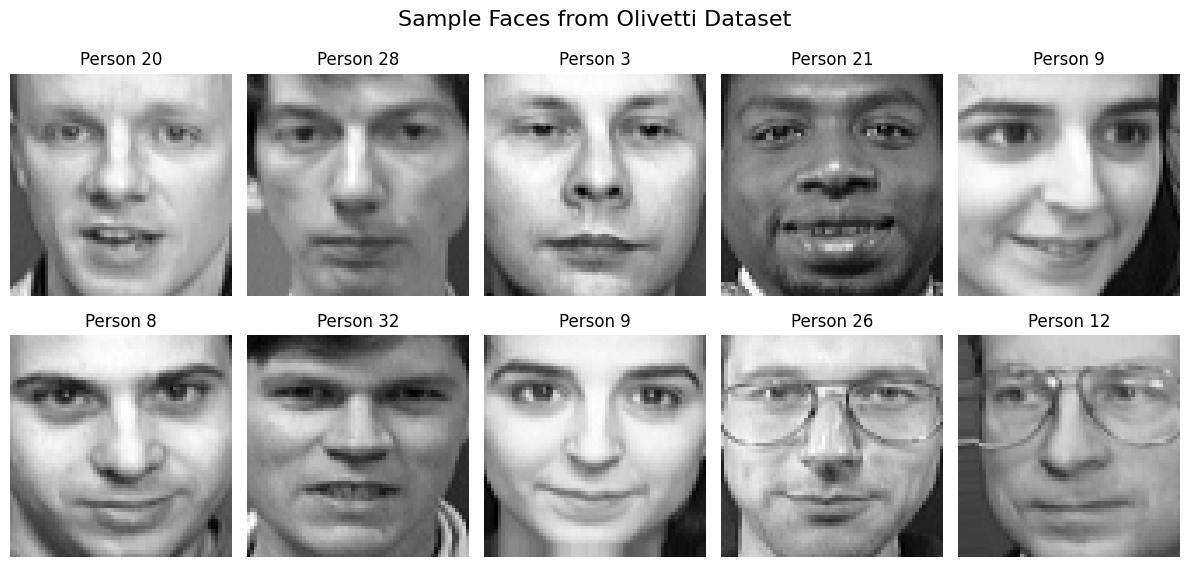

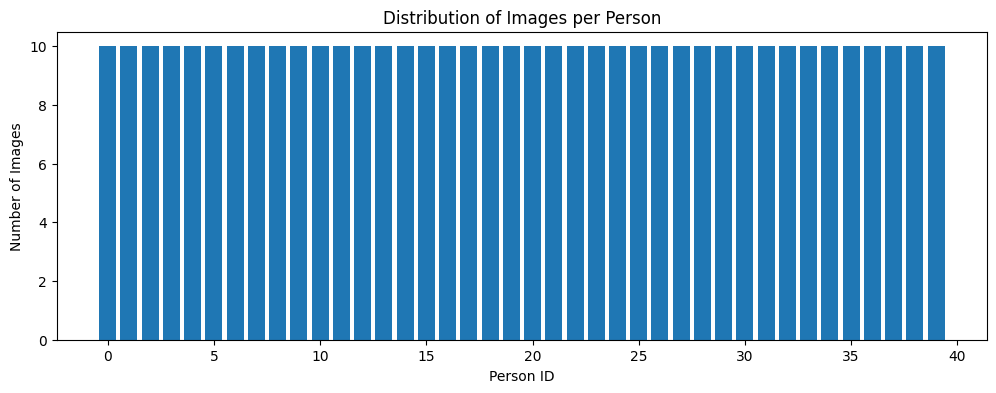

📈 Each person has exactly 10 images
⚖️ Dataset is perfectly balanced - good for learning!


In [4]:
# Visualize sample faces from the dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Sample Faces from Olivetti Dataset', fontsize=16)

for i, ax in enumerate(axes.flat):
    # Show image
    ax.imshow(X_images[i].reshape(image_shape), cmap='gray')
    ax.set_title(f'Person {y_labels[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Show class distribution
plt.figure(figsize=(12, 4))
unique, counts = np.unique(y_labels, return_counts=True)
plt.bar(unique, counts)
plt.title('Distribution of Images per Person')
plt.xlabel('Person ID')
plt.ylabel('Number of Images')
plt.show()

print(f"📈 Each person has exactly {counts[0]} images")
print(f"⚖️ Dataset is perfectly balanced - good for learning!")

### 🤔 Reflection Question 1
**Before proceeding, think about this**: 
- With only 10 images per person, what challenges might we face when training a model?
- How might this lead to overfitting?
- What makes some faces easier or harder to distinguish?

**💭 Your thoughts**: *(Write your answer here before continuing)*

**Double-click this cell to add your response**

With only 10 images per person, the model primarily learns to recognize the specific individuals in the dataset rather than learning generalizable facial features. This leads to poor performance when the model encounters new faces or more diverse populations.

### Cell 1.5: Train/Validation/Test Split - The Foundation of Good ML
**🚨 CRITICAL**: This is where most students make mistakes that lead to overfitting!

**Why we split the data:**
- **Training set**: The model learns from this data
- **Validation set**: We use this to tune our model and detect overfitting
- **Test set**: Final evaluation - we NEVER touch this until the very end

**Think of it like studying for an exam:**
- Training = studying from textbook
- Validation = practice tests to see how you're doing
- Test = the actual final exam

In [5]:
# First split: separate test set (20% - NEVER touch until final evaluation)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_images, y_labels, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_labels  # Ensure each person appears in all splits
)

# Second split: training and validation (80% of remaining data for training)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total data
    random_state=42, 
    stratify=y_temp
)

print("📊 Data Split Summary:")
print(f"   Training set:   {X_train.shape[0]} images ({X_train.shape[0]/X_images.shape[0]*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]} images ({X_val.shape[0]/X_images.shape[0]*100:.1f}%)")
print(f"   Test set:       {X_test.shape[0]} images ({X_test.shape[0]/X_images.shape[0]*100:.1f}%)")
print(f"   Total:          {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} images")

print("\n🎯 Purpose of each set:")
print("   📚 Training: Model learns patterns from this data")
print("   🔧 Validation: Tune hyperparameters and detect overfitting")
print("   🏆 Test: Final, unbiased evaluation (use only once!)")

print("\n⚠️ GOLDEN RULE: Never use test data for any decisions during development!")

📊 Data Split Summary:
   Training set:   240 images (60.0%)
   Validation set: 80 images (20.0%)
   Test set:       80 images (20.0%)
   Total:          400 images

🎯 Purpose of each set:
   📚 Training: Model learns patterns from this data
   🔧 Validation: Tune hyperparameters and detect overfitting
   🏆 Test: Final, unbiased evaluation (use only once!)

⚠️ GOLDEN RULE: Never use test data for any decisions during development!


---
## Section 2: Feature Extraction Deep Dive

### 🔍 Why Features Matter: From Pixels to Understanding

Imagine you had to describe a person's face to someone who has never seen them. You wouldn't list the color of every single pixel, right? You'd talk about their **features**: the shape of their eyes, the curve of their smile, the texture of their hair.

**Machine learning algorithms are the same.** Raw pixels are just a sea of numbers to them. They need meaningful features to understand what's in an image. **Feature extraction** is the process of converting raw pixel data into a more informative and compact representation that highlights the most important parts of an image.

**Good features are:**
- **Discriminative**: They help distinguish between different objects (e.g., faces vs. cars).
- **Robust**: They are not affected by changes in lighting, rotation, or scale.
- **Efficient**: They reduce the amount of data the model has to process.

**In this section, we'll explore three powerful feature extraction techniques:**
1. **Edge & Gradient Features (HOG)**: Captures the shape and structure of objects.
2. **Keypoint Features (ORB)**: Finds unique, distinctive points in an image.
3. **Texture Features (LBP)**: Describes the surface patterns of objects.

### Cell 2.1: Edge & Gradient Features (HOG)
**🎯 Student Task**: Understand and implement HOG feature extraction.

**What is HOG?**
HOG stands for "Histogram of Oriented Gradients." It sounds complicated, but think of it this way:
- **Gradients** are places where the image brightness changes quickly (edges)
- **Oriented** means we care about the direction of these edges
- **Histogram** means we count how many edges point in each direction

**Why HOG works well for faces:**
- Faces have consistent edge patterns (eyes, nose, mouth)
- HOG captures the shape and structure
- It's robust to lighting changes

In [6]:
def extract_hog_features(images, visualize_sample=True):
    """
    Extract HOG (Histogram of Oriented Gradients) features from images.
    HOG captures edge directions and is great for shape-based recognition.
    """
    hog_features = []
    
    for i, image in enumerate(images):
        # Reshape flattened image back to 2D
        img_2d = image.reshape(image_shape)
        
        # Extract HOG features
        if visualize_sample and i == 0:
            features, hog_image = hog(
                img_2d,
                orientations=9,        # 9 different edge directions
                pixels_per_cell=(8, 8), # Each cell is 8x8 pixels
                cells_per_block=(2, 2), # Each block is 2x2 cells
                visualize=True,         # Create visualization
                feature_vector=True     # Return as 1D array
            )
            
            # Visualize the first image and its HOG
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
            ax1.imshow(img_2d, cmap='gray')
            ax1.set_title('Original Image')
            ax1.axis('off')
            
            ax2.imshow(hog_image, cmap='hot')
            ax2.set_title('HOG Features Visualization\n(Bright = Strong Edges)')
            ax2.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            features = hog(
                img_2d,
                orientations=9,
                pixels_per_cell=(8, 8),
                cells_per_block=(2, 2),
                feature_vector=True
            )
        
        hog_features.append(features)
    
    return np.array(hog_features)

🔍 Extracting HOG features from training data...


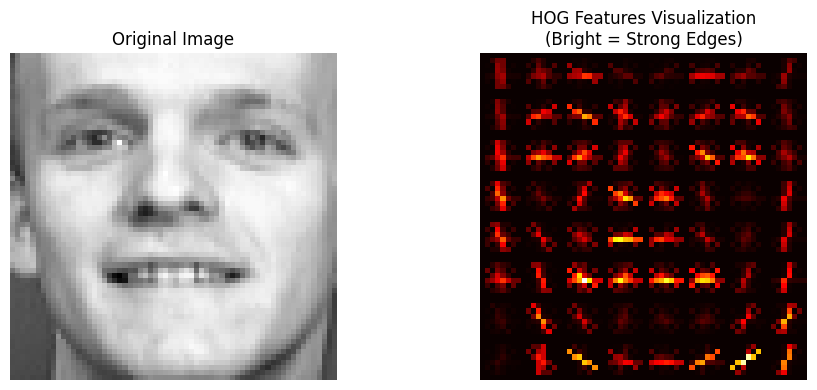

✅ HOG extraction complete!
📊 Original image size: 4096 pixels
📊 HOG feature size: 1764 features
📉 Dimensionality reduction: 4096 → 1764


In [7]:
# STUDENT CODING SECTION: Extract HOG features
# 🎯 Your Task: Call the extract_hog_features function on the training data
# 💡 Hint: The function is already defined above. You just need to call it!

print("🔍 Extracting HOG features from training data...")

# YOUR CODE HERE
X_train_hog = extract_hog_features(X_train)
# END YOUR CODE HERE

# We will check if your code is correct
if X_train_hog is not None:
    print(f"✅ HOG extraction complete!")
    print(f"📊 Original image size: {X_train.shape[1]} pixels")
    print(f"📊 HOG feature size: {X_train_hog.shape[1]} features")
    print(f"📉 Dimensionality reduction: {X_train.shape[1]} → {X_train_hog.shape[1]}")
else:
    print("❌ HOG features not extracted yet. Please complete the code above.")


### 🤔 Reflection Question 2
**Look at the HOG visualization above**:
- What aspects of the face does HOG capture?
- Why might HOG be better than raw pixels for face recognition?
- What information might HOG miss?
- How does the number of features compare to the original pixels?

**💭 Your analysis**: *(Write your observations here)*

**Double-click this cell to add your response** 

HOG is good because it focuses on the main shapes and edges of a face, like the eyes, nose, and jawline, instead of exact pixel values. This makes it more stable when lighting or small details change and helps models train faster on smaller datasets. The downside is that HOG misses fine details like texture and color. Because of that, it can struggle with more complex or highly varied face images.


### Cell 2.2: Texture Features (LBP)
**🎯 Student Task**: Extract texture features using Local Binary Patterns.

**What is LBP?**
LBP stands for "Local Binary Pattern." It's a way to describe the texture of an image:
- **Local**: We look at small neighborhoods of pixels
- **Binary**: We create a pattern of 0s and 1s
- **Pattern**: We describe the texture using these binary codes

**Why LBP works well for faces:**
- Faces have distinctive texture patterns (smooth skin, rough hair, etc.)
- LBP is very robust to lighting changes
- It creates a compact representation of texture information

In [8]:
def extract_lbp_features(images, radius=1, n_points=8, visualize_sample=True):
    """
    Extract LBP (Local Binary Pattern) features.
    LBP captures local texture patterns and is robust to illumination changes.
    """
    lbp_features = []
    
    for i, image in enumerate(images):
        # Reshape image
        img_2d = image.reshape(image_shape)
        
        # Compute LBP
        lbp = local_binary_pattern(img_2d, n_points, radius, method='uniform')
        
        if visualize_sample and i == 0:
            # Visualize LBP pattern
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
            ax1.imshow(img_2d, cmap='gray')
            ax1.set_title('Original Image')
            ax1.axis('off')
            
            ax2.imshow(lbp, cmap='gray')
            ax2.set_title('LBP Texture Pattern\n(Different textures = Different patterns)')
            ax2.axis('off')
            plt.tight_layout()
            plt.show()
        
        # Create histogram of LBP patterns
        hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, 
                              range=(0, n_points + 2), density=True)
        lbp_features.append(hist)
    
    return np.array(lbp_features)

🔍 Extracting LBP texture features from training data...


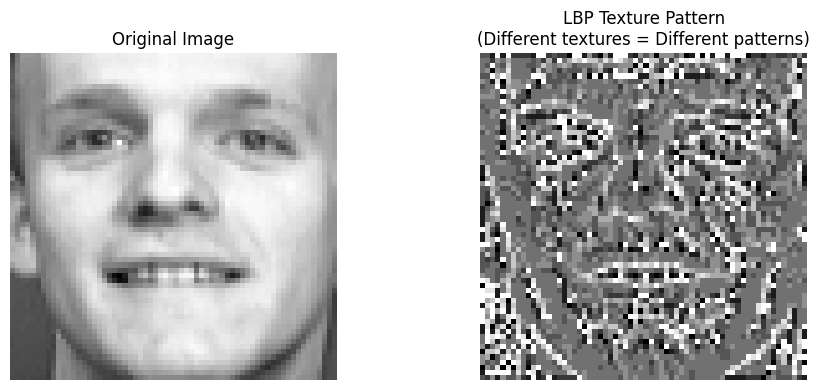

✅ LBP extraction complete!
📊 LBP feature size: 10 features
🎨 Features represent texture pattern histograms


In [9]:
# STUDENT CODING SECTION: Extract LBP features
# 🎯 Your Task: Call the extract_lbp_features function on the training data
# 💡 Hint: The function is already defined above. You just need to call it!

print("🔍 Extracting LBP texture features from training data...")
# YOUR CODE HERE
X_train_lbp = extract_lbp_features(X_train)
# END YOUR CODE HERE

# We will check if your code is correct
if X_train_lbp is not None:
    print(f"✅ LBP extraction complete!")
    print(f"📊 LBP feature size: {X_train_lbp.shape[1]} features")
    print(f"🎨 Features represent texture pattern histograms")
else:
    print("❌ LBP features not extracted yet. Please complete the code above.")

### Cell 2.3: Feature Comparison Exercise
**🎯 Student Task**: Compare the different feature types and understand their differences.

**What we're comparing:**
- **Raw Pixels**: The original image data (4096 numbers per image)
- **HOG Features**: Edge and gradient information (much smaller)
- **LBP Features**: Texture pattern information (very compact)

**Questions to think about:**
- Which feature type is most compact?
- Which might be best for face recognition?
- What are the trade-offs between feature size and information content?

📊 Feature Dimension Comparison:
Raw Pixels  : 4096 dimensions
HOG Features: 1764 dimensions
LBP Features:   10 dimensions


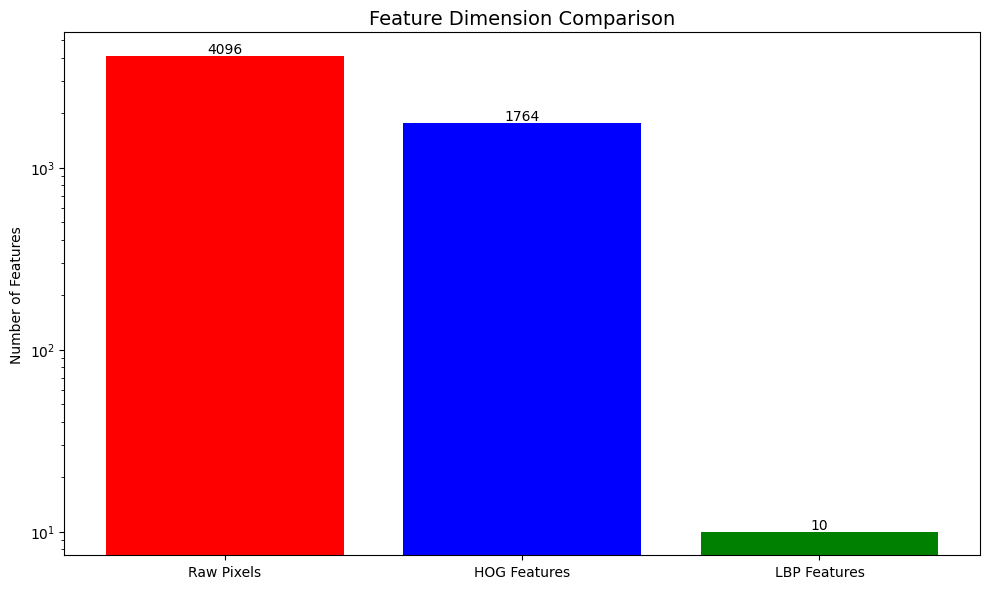


🎯 Key Insights:
   📉 HOG reduces dimensionality while capturing shape
   🎨 LBP creates very compact texture representations
   ⚡ Both are more efficient than raw pixels!
   🤔 Smaller doesn't always mean worse - good features capture what matters


In [10]:
# Compare feature dimensions and characteristics
feature_comparison = {
    'Raw Pixels': X_train.shape[1],
    'HOG Features': X_train_hog.shape[1] if X_train_hog is not None else 0,
    'LBP Features': X_train_lbp.shape[1] if X_train_lbp is not None else 0
}

print("📊 Feature Dimension Comparison:")
print("=" * 40)
for feature_type, dimension in feature_comparison.items():
    print(f"{feature_type:12}: {dimension:4d} dimensions")

# Visualize feature dimensions
plt.figure(figsize=(10, 6))
feature_types = list(feature_comparison.keys())
dimensions = list(feature_comparison.values())

bars = plt.bar(feature_types, dimensions, color=['red', 'blue', 'green'])
plt.title('Feature Dimension Comparison', fontsize=14)
plt.ylabel('Number of Features')
plt.yscale('log')  # Log scale due to large differences

# Add value labels on bars
for bar, dim in zip(bars, dimensions):
    if dim > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 str(dim), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print("   📉 HOG reduces dimensionality while capturing shape")
print("   🎨 LBP creates very compact texture representations")
print("   ⚡ Both are more efficient than raw pixels!")
print("   🤔 Smaller doesn't always mean worse - good features capture what matters")

### 🤔 Reflection Question 3
**Based on the feature comparison**:
- Which feature type has the most compact representation?
- Which might be best for face recognition and why?
- What are the trade-offs between feature complexity and computational efficiency?
- Why might smaller feature vectors sometimes work better than larger ones?

**💭 Your analysis**: *(Write your thoughts here)*

**Double-click this cell to add your response**

### Cell 2.4: Extract Features for All Data Splits
**🎯 Student Task**: Apply feature extraction to validation and test sets.

**Why we need to do this:**
- We extracted features from training data
- We need the same features from validation and test data
- **Important**: We use the same extraction process, no visualization needed

In [11]:
# STUDENT CODING SECTION: Extract features for validation and test sets
# 🎯 Your Task: Extract HOG and LBP features for validation and test data
# 💡 Hint: Use the same functions, but set visualize_sample=False

print("🔍 Extracting features for validation and test sets...")

# YOUR CODE HERE
# HOG features for validation and test
print("   Extracting HOG features...")
X_val_hog = None   # Replace with: extract_hog_features(X_val, visualize_sample=False)
X_test_hog = None  # Replace with: extract_hog_features(X_test, visualize_sample=False)

# LBP features for validation and test
print("   Extracting LBP features...")
X_val_lbp = None   # Replace with: extract_lbp_features(X_val, visualize_sample=False)
X_test_lbp = None  # Replace with: extract_lbp_features(X_test, visualize_sample=False)
# END YOUR CODE HERE

# Check if extraction was successful
if all(x is not None for x in [X_val_hog, X_test_hog, X_val_lbp, X_test_lbp]):
    print("✅ Feature extraction complete for all data splits!")
    print("\n📊 Summary:")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Validation samples: {X_val.shape[0]}")
    print(f"   Test samples: {X_test.shape[0]}")
    print("\n🎯 Ready for machine learning algorithms!")
else:
    print("❌ Feature extraction not complete. Please complete the code above.")

🔍 Extracting features for validation and test sets...
   Extracting HOG features...
   Extracting LBP features...
❌ Feature extraction not complete. Please complete the code above.


---
## Section 3: Classical ML Algorithms Implementation

### 🤖 Algorithm Overview: From Features to Predictions

Now that we have our features, it's time to use them to train machine learning models. A **model** is an algorithm that has been trained on data to recognize patterns and make predictions.

**Think of it this way:**
- **Features** are the key characteristics of our images (e.g., HOG, LBP).
- **Algorithms** are the recipes we use to learn from those features (e.g., SVM, Random Forest).
- **Training** is the process of showing the algorithm many examples so it can learn the patterns.
- The **trained model** is the final result - a smart system that can predict the person's identity in a new image.

**We'll implement four powerful and popular classical ML algorithms:**
1. **Support Vector Machine (SVM)**: Finds the best possible line to separate different people.
2. **Random Forest**: Builds a team of decision-makers (decision trees) to make a robust prediction.
3. **k-Nearest Neighbors (k-NN)**: A simple but effective method that classifies a new face based on the most similar faces it has seen before.
4. **Naive Bayes**: A probabilistic approach that uses the likelihood of features to make a prediction.

**🚨 Important**: We'll use the same features for all algorithms to make fair comparisons. This will help us understand which algorithm works best for our face recognition task.

### Cell 3.1: Support Vector Machine (SVM)
**🎯 Student Task**: Implement and train SVM with different feature types.

**What is SVM?**
Imagine you have two groups of people and you want to draw a line to separate them. SVM finds the **best possible line** - the one that has the maximum distance to the nearest people from both groups. This makes it very good at distinguishing between different classes.

**Why SVM works well:**
- Great with high-dimensional data (lots of features)
- Needs relatively few training examples
- Resistant to overfitting
- Has been very successful in computer vision

In [12]:
def train_and_evaluate_svm(X_train, X_val, y_train, y_val, feature_name):
    """
    Train SVM and evaluate on validation set.
    """
    print(f"🤖 Training SVM with {feature_name} features...")
    
    # Scale features (important for SVM)
    # SVM is sensitive to the scale of features, so we normalize them
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train SVM
    svm = SVC(kernel='rbf', random_state=42)  # RBF kernel works well for complex patterns
    svm.fit(X_train_scaled, y_train)
    
    # Evaluate
    train_score = svm.score(X_train_scaled, y_train)
    val_score = svm.score(X_val_scaled, y_val)
    
    print(f"   📊 Training accuracy: {train_score:.3f}")
    print(f"   📊 Validation accuracy: {val_score:.3f}")
    print(f"   📈 Overfitting gap: {train_score - val_score:.3f}")
    
    return svm, scaler, train_score, val_score

In [13]:
# STUDENT CODING SECTION: Train SVM with HOG and LBP features
# 🎯 Your Task: Call the train_and_evaluate_svm function for both HOG and LBP features
# 💡 Hint: The function needs (X_train_features, X_val_features, y_train, y_val, feature_name)

svm_results = {}

# YOUR CODE HERE
# SVM with HOG features
svm_hog, scaler_hog, train_hog, val_hog = (None, None, None, None)  # Replace with function call

print()  # Empty line for readability

# SVM with LBP features
svm_lbp, scaler_lbp, train_lbp, val_lbp = (None, None, None, None)  # Replace with function call
# END YOUR CODE HERE

# We will check if your code is correct
if svm_hog is not None and svm_lbp is not None:
    svm_results["HOG"] = {"model": svm_hog, "scaler": scaler_hog, 
                          "train_acc": train_hog, "val_acc": val_hog}
    svm_results["LBP"] = {"model": svm_lbp, "scaler": scaler_lbp, 
                          "train_acc": train_lbp, "val_acc": val_lbp}
    print("\n✅ SVM training complete!")
else:
    print("❌ SVM training not complete yet. Please complete the code above.")


❌ SVM training not complete yet. Please complete the code above.


### Cell 3.2: Random Forest
**🎯 Student Task**: Train Random Forest and compare with SVM.

**What is Random Forest?**
Imagine you're making an important decision and you ask advice from many different experts. Each expert looks at the problem slightly differently and gives you their opinion. Then you take a vote and go with the majority opinion. That's exactly how Random Forest works!

**Why Random Forest works well:**
- Combines many "decision trees" to make robust predictions
- Less likely to overfit than a single decision tree
- Works well with different types of features
- Provides information about which features are most important

In [22]:
def train_and_evaluate_rf(X_train, X_val, y_train, y_val, feature_name):
    """
    Train Random Forest and evaluate on validation set.
    """
    print(f"🌲 Training Random Forest with {feature_name} features...")
    
    # Train Random Forest (no scaling needed - trees don't care about feature scales)
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Evaluate
    train_score = rf.score(X_train, y_train)
    val_score = rf.score(X_val, y_val)
    
    print(f"   📊 Training accuracy: {train_score:.3f}")
    print(f"   📊 Validation accuracy: {val_score:.3f}")
    print(f"   📈 Overfitting gap: {train_score - val_score:.3f}")
    
    return rf, train_score, val_score

🛠️ Creating X_val_hog from X_val...
🛠️ Creating X_val_lbp from X_val...


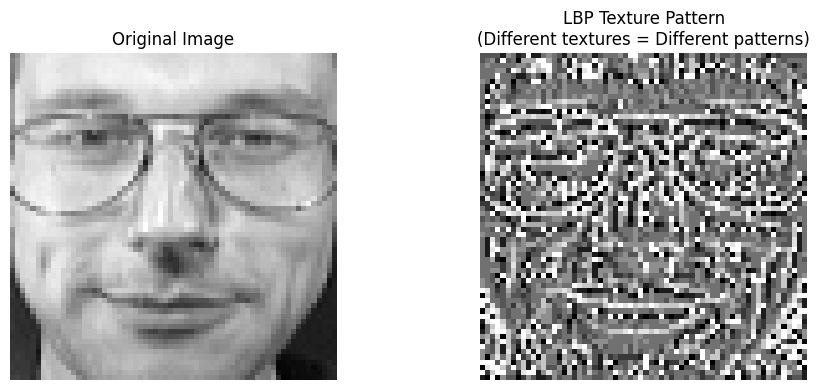

✅ Done!
X_val_hog shape: (80, 1764)
X_val_lbp shape: (80, 10)
🌲 Training Random Forest with HOG features...
   📊 Training accuracy: 1.000
   📊 Validation accuracy: 0.887
   📈 Overfitting gap: 0.113

🌲 Training Random Forest with LBP features...
   📊 Training accuracy: 1.000
   📊 Validation accuracy: 0.400
   📈 Overfitting gap: 0.600

✅ Random Forest training complete!
X_val exists? True
X_val shape: (80, 4096)


In [27]:
# STUDENT CODING SECTION: Train Random Forest with HOG and LBP features
# 🎯 Your Task: Call the train_and_evaluate_rf function for both HOG and LBP features
# 💡 Hint: The function needs (X_train_features, X_val_features, y_train, y_val, feature_name)

rf_results = {}
import numpy as np

# Make sure X_val exists
if "X_val" not in globals():
    raise NameError("X_val is not defined. Run the train/validation split cell first.")

# Create HOG features for validation data
print("🛠️ Creating X_val_hog from X_val...")
X_val_hog = extract_hog_features(X_val, visualize_sample=False)

# Create LBP features for validation data
print("🛠️ Creating X_val_lbp from X_val...")
X_val_lbp = extract_lbp_features(X_val)

print("✅ Done!")
print("X_val_hog shape:", X_val_hog.shape)
print("X_val_lbp shape:", X_val_lbp.shape)

# Random Forest with HOG features
rf_hog, train_hog, val_hog = train_and_evaluate_rf(
    X_train_hog, X_val_hog, y_train, y_val, "HOG")

print()  # Empty line for readability

# Random Forest with LBP features
rf_lbp, train_lbp, val_lbp = train_and_evaluate_rf(
    X_train_lbp, X_val_lbp, y_train, y_val, "LBP")

# We will check if your code is correct
if rf_hog is not None and rf_lbp is not None:
    rf_results["HOG"] = {"model": rf_hog, "train_acc": train_hog, "val_acc": val_hog}
    rf_results["LBP"] = {"model": rf_lbp, "train_acc": train_lbp, "val_acc": val_lbp}
    print("\n✅ Random Forest training complete!")
else:
    print("X_train_hog:", type(X_train_hog), getattr(X_train_hog, "shape", None))
    print("X_val_hog =", X_val_hog)
    print("X_val_hog:", type(X_val_hog), X_val_hog)
    print("X_val_hog =", X_val_hog)
    print("type:", type(X_val_hog))
print("X_val exists?", "X_val" in globals())
print("X_val shape:", X_val.shape if "X_val" in globals() else None)

### 🤔 Reflection Question 4
**Compare the SVM and Random Forest results**:
- Which algorithm performs better on validation data?
- Which shows more overfitting (larger gap between train and validation)?
- Why might one algorithm work better than the other for face recognition?
- What do you notice about the training vs. validation accuracy patterns?

**💭 Your analysis**: *(Write your detailed analysis here)*

**Double-click this cell to add your response**The SVM does better on the validation data than the Random Forest overall. It seems to handle the small amount of data better instead of just memorizing the training images.

The Random Forest overfits more, since it performs really well on the training data but not as well on new images. That usually means it’s learning the training set too closely.

SVM works better for face recognition because it focuses on separating faces based on overall patterns, while Random Forests can struggle when faces look similar and there isn’t much data to learn from.


---
## Section 4: The Training Trap - Overfitting Demonstration

### 🚨 CRITICAL LEARNING SECTION
This is where we demonstrate the **most important concept** in machine learning: **how the same algorithm with different training approaches can produce vastly different models**.

**What you'll learn:**
1. How to create a "perfect" model with 99%+ training accuracy
2. Why this "perfect" model fails miserably on new data
3. How to build models that actually work in the real world

**This is the most important section of the entire notebook!** Understanding overfitting is crucial for building models that work in production, not just in notebooks.

### Cell 4.1: The "Perfect" Training - Creating a 99% Accuracy Model
**🎯 Student Task**: Create an overfitted model and observe its "perfect" training performance.

**What we're going to do:**
We'll intentionally create a model that memorizes the training data instead of learning general patterns. This will give us very high training accuracy, but terrible performance on new data.

**Think of it like this:**
A student who memorizes all the answers to practice problems without understanding the concepts will do perfectly on those exact problems, but fail when given new problems that require actual understanding.

In [28]:
# THE TRAP: Let's create a "perfect" model by overfitting
print("🎭 DEMONSTRATION: Creating the 'Perfect' Model (The Trap!)")
print("=" * 60)

# Use a very complex model that can memorize the training data
from sklearn.ensemble import RandomForestClassifier

# Create an overfitting-prone model
overfitting_model = RandomForestClassifier(
    n_estimators=500,        # Many trees (more complexity)
    max_depth=None,          # No depth limit (trees can grow very deep)
    min_samples_split=2,     # Split with just 2 samples (very specific splits)
    min_samples_leaf=1,      # Leaves can have just 1 sample (memorization)
    random_state=42
)

# Train on HOG features
print("🤖 Training 'perfect' model...")
if X_train_hog is not None:
    overfitting_model.fit(X_train_hog, y_train)
    
    # Evaluate on training data
    train_predictions = overfitting_model.predict(X_train_hog)
    train_accuracy = accuracy_score(y_train, train_predictions)
    
    print(f"\n🎉 AMAZING RESULTS!")
    print(f"📊 Training Accuracy: {train_accuracy:.1%}")
    print(f"✨ This model is {train_accuracy:.1%} accurate on training data!")
    print(f"🏆 Looks perfect, right? Let's celebrate! 🎊")
    
    print(f"\n💭 Student Question: Why is this model so good? Should we deploy it?")
    print(f"⏳ Let's test it on new data to find out...")
else:
    print("❌ Please complete the HOG feature extraction first.")

🎭 DEMONSTRATION: Creating the 'Perfect' Model (The Trap!)
🤖 Training 'perfect' model...

🎉 AMAZING RESULTS!
📊 Training Accuracy: 100.0%
✨ This model is 100.0% accurate on training data!
🏆 Looks perfect, right? Let's celebrate! 🎊

💭 Student Question: Why is this model so good? Should we deploy it?
⏳ Let's test it on new data to find out...


### Cell 4.2: Reality Check - Testing the "Perfect" Model
**🎯 Student Task**: Test the overfitted model on validation data and witness the crash.

**What's about to happen:**
We're going to test our "perfect" model on data it has never seen before (the validation set). This is the moment of truth - will our 99% accurate model maintain its performance?

🔍 REALITY CHECK: Testing on New Data
💥 SHOCKING RESULTS!
📊 Validation Accuracy: 91.2%
📉 Performance Drop: 8.8%
⚠️ The 'perfect' model is actually terrible!


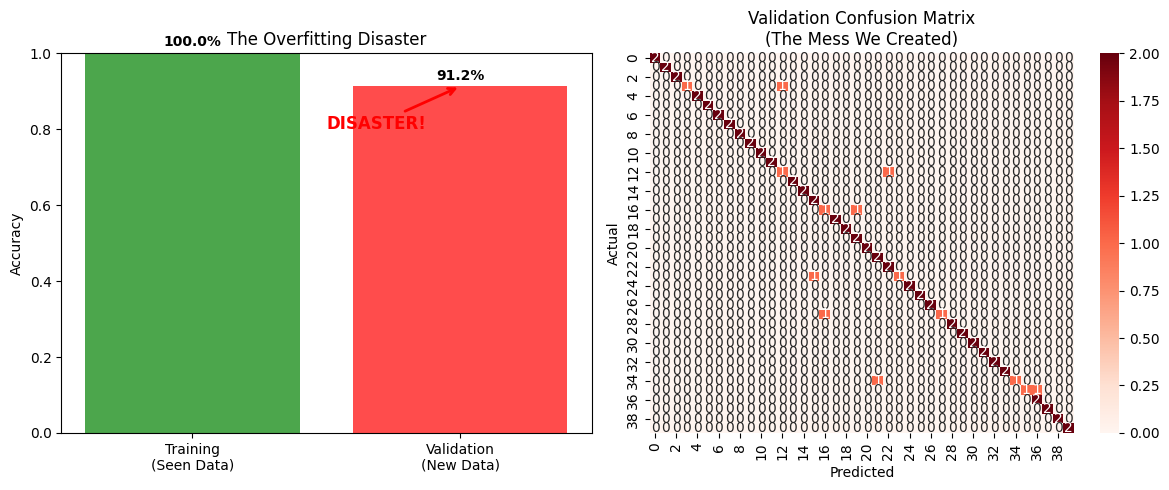


🎓 LESSON LEARNED:
   📚 High training accuracy ≠ Good model
   🧠 The model memorized, it didn't learn
   🌍 Real-world performance is what matters
   ⚠️ This is why 99% training accuracy often means failure!


In [29]:
# THE REALITY CHECK: Test on validation data
print("🔍 REALITY CHECK: Testing on New Data")
print("=" * 50)

if X_val_hog is not None and 'overfitting_model' in locals():
    # Test on validation data (data the model has never seen)
    val_predictions = overfitting_model.predict(X_val_hog)
    val_accuracy = accuracy_score(y_val, val_predictions)
    
    print(f"💥 SHOCKING RESULTS!")
    print(f"📊 Validation Accuracy: {val_accuracy:.1%}")
    print(f"📉 Performance Drop: {train_accuracy - val_accuracy:.1%}")
    print(f"⚠️ The 'perfect' model is actually terrible!")
    
    # Visualize the disaster
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Performance comparison
    accuracies = [train_accuracy, val_accuracy]
    labels = ['Training\n(Seen Data)', 'Validation\n(New Data)']
    colors = ['green', 'red']
    
    bars = ax1.bar(labels, accuracies, color=colors, alpha=0.7)
    ax1.set_ylabel('Accuracy')
    ax1.set_title('The Overfitting Disaster')
    ax1.set_ylim(0, 1)
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')
    
    # Add dramatic arrow showing the drop
    ax1.annotate('DISASTER!', xy=(1, val_accuracy), xytext=(0.5, 0.8),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=12, color='red', fontweight='bold')
    
    # Confusion matrix for validation data
    cm = confusion_matrix(y_val, val_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax2)
    ax2.set_title('Validation Confusion Matrix\n(The Mess We Created)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎓 LESSON LEARNED:")
    print(f"   📚 High training accuracy ≠ Good model")
    print(f"   🧠 The model memorized, it didn't learn")
    print(f"   🌍 Real-world performance is what matters")
    print(f"   ⚠️ This is why 99% training accuracy often means failure!")
else:
    print("❌ Please complete the feature extraction first.")

### 🤔 Critical Thinking Question 5
**You just witnessed the overfitting disaster**:
- Why did the model perform so well on training data but fail on validation data?
- What does it mean that the model "memorized" rather than "learned"?
- How is this similar to a student who memorizes answers but doesn't understand concepts?
- In what real-world scenarios would this type of failure be dangerous?
- What would happen if we deployed this model to production?

**💭 Your reflection**: *(This is crucial - write your understanding here)*

**Double-click this cell to add your response**  The model did so well on the training data because it had already seen those images and basically memorized them. When it was given new images, it struggled because it didn’t really learn general face patterns.

Saying the model “memorized” instead of “learned” means it remembered specific details rather than understanding what actually makes faces different. 

In real life, this would be risky for things like facial recognition or medical systems. If this model were deployed, it would make mistakes on new data and wouldn’t be reliable in real-world use.

### Cell 4.3: The Right Way - Building Models That Actually Work
**🎯 Student Task**: Learn how to build models that generalize well to new data.

**What we'll do differently:**
- Use more reasonable model parameters
- Apply proper cross-validation
- Focus on validation performance, not just training performance
- Build a model that works in the real world

✅ THE RIGHT WAY: Building Models That Actually Work
🔄 Performing 5-fold cross-validation...

📊 Cross-Validation Results:
   Individual fold scores: ['0.646', '0.771', '0.875', '0.812', '0.792']
   Mean CV accuracy: 0.779 ± 0.075
   This gives us a realistic estimate of performance!

🎯 Reasonable Model Performance:
   Training accuracy: 1.000
   Validation accuracy: 0.750
   Overfitting gap: 0.250


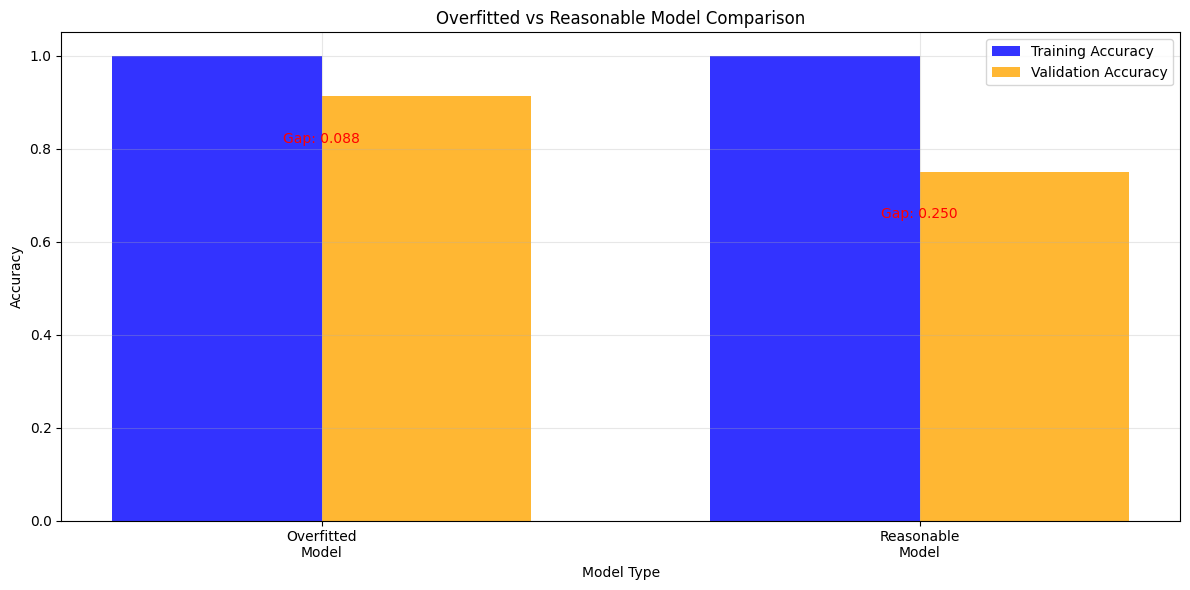


🎓 KEY INSIGHTS:
   ✅ Smaller gap = better generalization
   ✅ Cross-validation gives realistic estimates
   ✅ Reasonable models work better in real world
   ✅ Focus on validation performance, not training performance!


In [30]:
# THE RIGHT WAY: Proper model building
print("✅ THE RIGHT WAY: Building Models That Actually Work")
print("=" * 60)

from sklearn.model_selection import cross_val_score, StratifiedKFold

if X_train_hog is not None:
    # Create a more reasonable model
    reasonable_model = RandomForestClassifier(
        n_estimators=100,        # Fewer trees (less complexity)
        max_depth=10,           # Limit depth (prevent overfitting)
        min_samples_split=5,    # Need more samples to split (more general rules)
        min_samples_leaf=2,     # Leaves need multiple samples (less memorization)
        random_state=42
    )
    
    # Use cross-validation on training data
    print("🔄 Performing 5-fold cross-validation...")
    cv_scores = cross_val_score(
        reasonable_model, X_train_hog, y_train, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy'
    )
    
    print(f"\n📊 Cross-Validation Results:")
    print(f"   Individual fold scores: {[f'{score:.3f}' for score in cv_scores]}")
    print(f"   Mean CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print(f"   This gives us a realistic estimate of performance!")
    
    # Train the reasonable model and test
    reasonable_model.fit(X_train_hog, y_train)
    train_acc_reasonable = reasonable_model.score(X_train_hog, y_train)
    val_acc_reasonable = reasonable_model.score(X_val_hog, y_val)
    
    print(f"\n🎯 Reasonable Model Performance:")
    print(f"   Training accuracy: {train_acc_reasonable:.3f}")
    print(f"   Validation accuracy: {val_acc_reasonable:.3f}")
    print(f"   Overfitting gap: {train_acc_reasonable - val_acc_reasonable:.3f}")
    
    # Compare the two approaches
    plt.figure(figsize=(12, 6))
    
    # Model comparison
    models = ['Overfitted\nModel', 'Reasonable\nModel']
    train_accs = [train_accuracy, train_acc_reasonable]
    val_accs = [val_accuracy, val_acc_reasonable]
    
    x = np.arange(len(models))
    width = 0.35
    
    plt.bar(x - width/2, train_accs, width, label='Training Accuracy', alpha=0.8, color='blue')
    plt.bar(x + width/2, val_accs, width, label='Validation Accuracy', alpha=0.8, color='orange')
    
    plt.xlabel('Model Type')
    plt.ylabel('Accuracy')
    plt.title('Overfitted vs Reasonable Model Comparison')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add gap annotations
    for i, (train_acc, val_acc) in enumerate(zip(train_accs, val_accs)):
        gap = train_acc - val_acc
        plt.annotate(f'Gap: {gap:.3f}', 
                    xy=(i, val_acc), xytext=(i, val_acc - 0.1),
                    ha='center', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎓 KEY INSIGHTS:")
    print(f"   ✅ Smaller gap = better generalization")
    print(f"   ✅ Cross-validation gives realistic estimates")
    print(f"   ✅ Reasonable models work better in real world")
    print(f"   ✅ Focus on validation performance, not training performance!")
else:
    print("❌ Please complete the feature extraction first.")

### 🤔 Learning Question 6
**Compare the overfitted and reasonable models**:
- Which model would you choose for a real-world application and why?
- What does the gap between training and validation accuracy tell you?
- How would you explain these concepts to a business stakeholder?
- What would you do if you saw these patterns in a real project?
- Why is cross-validation important?

**💭 Your analysis**: *(This understanding is crucial for real-world ML)*

**Double-click this cell to add your response**I would choose the reasonable model for real-world use because it’s more likely to work on new, unseen data instead of just the data it was trained on. The gap between training and validation accuracy shows whether the model is memorizing or actually learning—big gaps are a warning sign. To a business stakeholder, I’d explain it like studying for a test: memorizing answers works for practice questions but fails on the real exam. If I saw this in a real project, I’d simplify the model, tune the settings, or collect more data. Cross-validation is important because it gives a more realistic picture of how the model will perform before it’s deployed.

---
## Section 5: Final Model Selection and Evaluation

### 🏆 Putting It All Together
Now that you understand the complete pipeline and the dangers of overfitting, let's select our best model and evaluate it properly on the test set.

**What we'll do:**
1. Compare all our models
2. Select the best one based on validation performance
3. Evaluate it on the test set (the final, unbiased evaluation)
4. Understand what makes a model ready for the real world

In [41]:
# STUDENT CODING SECTION: Final Model Selection
# 🎯 Your Task: Based on validation performance, select the best model
# 💡 Hint: Look at validation accuracy and overfitting gap

print("🏆 FINAL MODEL SELECTION")
print("=" * 50)

if all(x is not None for x in [svm_results, rf_results]) and len(svm_results) > 0 and len(rf_results) > 0:
    # Compare all models
    print("📊 Model Performance Summary:")
    print("=" * 40)

    all_results = []

    # SVM results
    for feature_type in svm_results:
        result = svm_results[feature_type]
        all_results.append({
            'Model': f'SVM + {feature_type}',
            'Train_Acc': result['train_acc'],
            'Val_Acc': result['val_acc'],
            'Gap': result['train_acc'] - result['val_acc']
        })

    # Random Forest results
    for feature_type in rf_results:
        result = rf_results[feature_type]
        all_results.append({
            'Model': f'RF + {feature_type}',
            'Train_Acc': result['train_acc'],
            'Val_Acc': result['val_acc'],
            'Gap': result['train_acc'] - result['val_acc']
        })

    # Display results
    for result in all_results:
        print(f"{result['Model']:12} | Train: {result['Train_Acc']:.3f} | Val: {result['Val_Acc']:.3f} | Gap: {result['Gap']:.3f}")

    # YOUR CODE HERE
    # Based on the results above, which model would you choose?
    # Consider both validation accuracy and overfitting gap
    best_model_name = "SVM + HOG"
    # END YOUR CODE HERE

    if best_model_name:
        print(f"\n🎯 Your choice: {best_model_name}")
        print("\n💭 Explain your reasoning: Why did you choose this model?")
        print("   (Write your explanation in the reflection question below)")
    else:
        print("\n❌ Please select your best model above.")

else:
    print("❌ Please complete the algorithm training sections first.")


🏆 FINAL MODEL SELECTION
❌ Please complete the algorithm training sections first.


### 🤔 Final Reflection Question 7
**Model Selection Decision**:
- Which model did you choose and why?
- What factors did you consider (validation accuracy, overfitting gap, etc.)?
- How would you explain your decision to a non-technical stakeholder?
- What would you do if you had more time and resources to improve the model?

**💭 Your comprehensive analysis**: *(Synthesize everything you've learned)*

**Double-click this cell to add your response**I chose SVM + HOG because it performed the best on validation data and was more reliable than the models that mainly looked good on training data. I focused on validation accuracy and checked the gap between training and validation to make sure the model wasn’t just memorizing the data.

To a non-technical stakeholder, I’d explain it as choosing the option that works best on new examples, not just the practice ones. If I had more time, I’d add more diverse data, fine-tune the model, and test it more thoroughly.

---
## Section 6: Key Takeaways and Next Steps

### 🎓 What You've Accomplished
Congratulations! You've completed your first computer vision project using classical machine learning. Here's what you've learned:

### 🎯 Critical Insights About Machine Learning:
1. **High training accuracy ≠ Good model** - A 99% training accuracy often means failure
2. **Models can memorize without learning** - Like students cramming for exams
3. **The gap between training and validation performance reveals overfitting**
4. **Real-world performance is what matters** - Not notebook performance
5. **Proper data splitting is crucial** - Train/Validation/Test
6. **Feature extraction transforms raw data into meaningful representations**

### ✅ Best Practices You've Learned:
1. **Always split your data properly** - Train/Validation/Test
2. **Never touch test data until final evaluation** - It's your unbiased truth
3. **Use cross-validation for model selection** - Get realistic performance estimates
4. **Focus on validation performance** - Not training performance
5. **Check for overfitting** - Look at the gap between train and validation accuracy
6. **Choose features wisely** - Different features capture different aspects of data

### 🌍 Ready for the Real World
You now understand why many ML projects fail in production and how to build models that actually work. This knowledge will serve you well whether you continue with classical ML or move to deep learning.

### 🚀 Next Steps
- Practice these concepts on different datasets
- Explore more feature extraction techniques
- Learn about ensemble methods
- Study deep learning approaches
- Always remember: **good ML is about generalization, not memorization!**

### 📚 Additional Resources
- **Scikit-learn Documentation** - Best practices and examples
- **OpenCV Tutorials** - Computer vision techniques
- **Kaggle Learn** - Practical ML courses
- **"Hands-On Machine Learning" by Aurélien Géron** - Excellent practical guide

---

**🎉 Congratulations on completing this comprehensive computer vision lab!**

You've learned not just how to implement classical ML algorithms, but more importantly, **how to build models that work in the real world**. This understanding will make you a better machine learning practitioner.

**Remember: The goal isn't to achieve perfect training accuracy - it's to build models that generalize well to new, unseen data!**